In [1]:
import numpy as np
import nolds
import scipy.io
import mne
import pandas as pd
import seaborn as sns
import pyqtgraph as pg
from scipy.io import loadmat
from scipy import stats
import matplotlib.pyplot as plt
import antropy as ent
from attractors import Attractor
from antropy import higuchi_fd
from pyrqa.settings import Settings
from pyrqa.neighbourhood import FixedRadius
from pyrqa.computation import RQAComputation
from pyrqa.time_series import TimeSeries
from pyrqa.result import RQAResult
from pyrqa.opencl import OpenCL
from pyrqa.settings import Settings
from pyrqa.time_series import TimeSeries
from pyrqa.neighbourhood import FixedRadius
from pyrqa.settings import Settings
from pyrqa.time_series import TimeSeries
from pyrqa.neighbourhood import FixedRadius
from pyrqa.metric import EuclideanMetric
from pyrqa.computation import RQAComputation
from pyrqa.metric import EuclideanMetric
from pyrqa.computation import RQAComputation
from pyrqa.settings import Settings
from pyrqa.neighbourhood import FixedRadius
from pyrqa.metric import EuclideanMetric
from pyrqa.image_generator import ImageGenerator
import numpy as np
import matplotlib.pyplot as plt
from antropy import higuchi_fd

In [2]:
# Load data
data = loadmat('/home/vincent/AAA_projects/MVCS/Neuroscience/downsampled/EEG_DS_Struct_0101.mat') # load your EEG data here
stim_data = pd.read_excel('/home/vincent/AAA_projects/MVCS/Neuroscience/EEG-tES-Chaos-Neural-Net/stim_data.xlsx') # load your stimulation data here
 
# Fill null values in 'Sub#' column
stim_data['Sub#'].fillna(method='ffill', inplace=True)

DSamp = data['DSamp']

# Get data parameters
triggers = DSamp[0][0][0]
EEGdata = DSamp[0][0][1]
fs = DSamp[0][0][2][0][0]
fsOld = DSamp[0][0][3][0][0]
time = DSamp[0][0][4][0]
label = DSamp[0][0][5]
nchan = DSamp[0][0][6][0][0]
rate = DSamp[0][0][7][0][0]
npt = DSamp[0][0][8][0][0]
Subj = DSamp[0][0][9][0]
ptrackerPerf = DSamp[0][0][10]
ptrackerTime = DSamp[0][0][11]
ptrackerfs = DSamp[0][0][12][0][0]

# List of unwanted channel names
unwanted_channels = ['BIP1', 'BIP2', 'RESP1']

# Create a mask where True indicates that the channel is not unwanted
mask = np.array([ch[0][0] not in unwanted_channels for ch in label])

# Filter out unwanted channels from the label data
filtered_label = label[mask]

# Convert the filtered list back to numpy array and replace the original label
label = np.array(filtered_label, dtype=object)

# Transpose EEGdata
EEGdata = EEGdata.T

# Filter out unwanted channels from the EEG data
filtered_EEGdata = EEGdata[:, mask]

# Transpose it back if needed
filtered_EEGdata = filtered_EEGdata.T

#Select subject
stim_data = stim_data[stim_data['Sub#'] == 1]

stim_data_df = pd.DataFrame(stim_data)


import numpy as np

def flatten(item):
    if isinstance(item, list):
        for subitem in item:
            yield from flatten(subitem)
    elif isinstance(item, np.ndarray):
        for subitem in item.flatten():
            yield from flatten(subitem)
    else:
        yield item

            
trigger_list = []  
for trigger in triggers[0]:
    trigger_list.append([list(flatten(trigger[0])),  # Time
                         list(flatten(trigger[1])),  # SampleNum
                         list(flatten(trigger[2])),  # FileNum
                         list(flatten(trigger[3])),  # EventType
                         list(flatten(trigger[4])),  # EventDescription
                         list(flatten(trigger[5])) if trigger[5].size else ['Unknown']  # StimType
                        ])


# Create DataFrame and transpose it
eeg_df = pd.DataFrame(filtered_EEGdata.T)  # Transpose the data

# Display the updated DataFrame

# We convert the labels list into a simple list (previously it was a list of numpy arrays)
simple_label = [label_item[0][0] for label_item in label]

eeg_df.columns = simple_label  # Assign column names

# Create DataFrames
triggers_df = pd.DataFrame(trigger_list, columns=["Time", "SampleNum", "EventType1", "EventType", "EventDescription", "StimType"])
triggers_df = triggers_df.drop(['EventType1', 'SampleNum'], axis=1)

In [17]:
print(eeg_df.shape)

(4227788, 33)


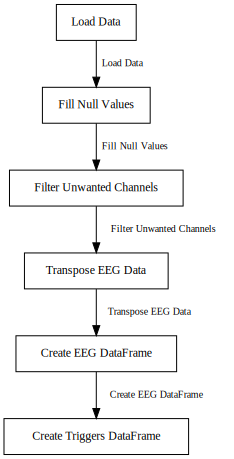

In [3]:
from graphviz import Digraph, Source

# Create the graph
graph = Digraph(format='png')

# Add nodes to the graph
graph.node('LoadData', shape='rect', label="Load Data", fontsize='12')
graph.node('FillNull', shape='rect', label="Fill Null Values", fontsize='12')
graph.node('FilterUnwanted', shape='rect', label="Filter Unwanted Channels", fontsize='12')
graph.node('TransposeEEG', shape='rect', label="Transpose EEG Data", fontsize='12')
graph.node('DataFrameEEG', shape='rect', label="Create EEG DataFrame", fontsize='12')
graph.node('DataFrameTriggers', shape='rect', label="Create Triggers DataFrame", fontsize='12')

# Add edges between nodes
graph.edge('LoadData', 'FillNull', label="Load Data", fontsize='10')
graph.edge('FillNull', 'FilterUnwanted', label="Fill Null Values", fontsize='10')
graph.edge('FilterUnwanted', 'TransposeEEG', label="Filter Unwanted Channels", fontsize='10')
graph.edge('TransposeEEG', 'DataFrameEEG', label="Transpose EEG Data", fontsize='10')
graph.edge('DataFrameEEG', 'DataFrameTriggers', label="Create EEG DataFrame", fontsize='10')

# Display the graph visualization directly in Jupyter Notebook/Lab
src = Source(graph.source)
src

In [13]:
# Assuming that stim_data_df looks something like this:
stim_data_df = pd.DataFrame({
    'Sub#': [1, 1, 1, 1, 1, 1],
    'Session': [1, 2, 3, 4, 5, 6],
    'File Num': [101, 102, 103, 104, 105, 106],
    'StimTypeBlock1': ['M30', 'M30', 'P30', 'F5', 'F5', 'P30'],
    'StimTypeBlock2': ['F30', 'F30', 'P0', 'M5', 'M5', 'P0'],
    'StimTypeBlock3': ['F0', 'F0', 'P5', 'M0', 'M0', 'P5'],
    'StimAmplitude_mA_block1': [1, 0.5, 0.5, 0.5, 1, 1],
    'StimAmplitude_mA_block2': [1, 0.5, 0.5, 0.5, 1, 1],
    'StimAmplitude_mA_block3': [1, 0.5, 0.5, 0.5, 1, 1],
})

# Also assuming that triggers_df looks something like this:
triggers_df = pd.DataFrame({
    'Time': [619.499, 654.746, 770.515, 805.571, 921.515, 956.651, 1072.551, 1107.578, 1819.593, 1854.888, 1970.669, 2005.715, 2121.644, 2156.695, 2272.756, 2307.798, 3019.822, 3019.924],
    'EventDescription': ['Stim Start', 'Stim Stop', 'Stim Start', 'Stim Stop', 'Stim Start', 'Stim Stop', 'Stim Start', 'Stim Stop', 'Stim Start', 'Stim Stop', 'Stim Start', 'Stim Stop', 'Stim Start', 'Stim Stop', 'Stim Start', 'Stim Stop', 'Stim Start', 'Stim Stop'],
    'StimType': ['M30', 'M30', 'M30', 'M30', 'M30', 'M30', 'M30', 'M30', 'M30', 'M30', 'M30', 'M30', 'M30', 'M30', 'M30', 'M30', 'M30', 'M30']
})

def get_stim_info(sub, session, stim_type):
    mask = (stim_data_df['Sub#'] == sub) & (stim_data_df['Session'] == session)
    matching_rows = stim_data_df[mask]
    amplitudes = []
    blocks = []
    file_nums = []

    for index, row in matching_rows.iterrows():
        for block in range(1, 4):
            if row[f'StimTypeBlock{block}'] == stim_type:
                amplitudes.append(row[f'StimAmplitude_mA_block{block}'])
                blocks.append(block)
                file_nums.append(row['File Num'])
    
    return amplitudes, blocks, file_nums

# Adding 'Sub#' and 'Session' columns to triggers_df
triggers_df['Sub#'] = 1
triggers_df['Session'] = 1

# Define unique_combinations before using it
unique_combinations = pd.concat([stim_data_df[["Sub#", "Session", "StimTypeBlock1"]], 
                                 stim_data_df[["Sub#", "Session", "StimTypeBlock2"]].rename(columns={"StimTypeBlock2": "StimTypeBlock1"}), 
                                 stim_data_df[["Sub#", "Session", "StimTypeBlock3"]].rename(columns={"StimTypeBlock3": "StimTypeBlock1"}), 
                                 triggers_df[["Sub#", "Session", "StimType"]].rename(columns={"StimType": "StimTypeBlock1"})]).drop_duplicates()

# Create a DataFrame to store the results
results_df = pd.DataFrame(columns=["Sub#", "Session", "StimType", "Amplitudes", "Block", "File Num"])

for _, row in unique_combinations.iterrows():
    sub = row["Sub#"]
    session = row["Session"]
    stim_type = row["StimTypeBlock1"]
    amplitudes, blocks, file_nums = get_stim_info(sub, session, stim_type)

    for amp, block, file_num in zip(amplitudes, blocks, file_nums):
        df_temp = pd.DataFrame([{"Sub#": sub, 
                                "Session": session, 
                                "StimType": stim_type, 
                                "Amplitudes": amp, 
                                "Block": block, 
                                "File Num": file_num}], 
                                columns=["Sub#", "Session", "StimType", "Amplitudes", "Block", "File Num"])
        results_df = pd.concat([results_df, df_temp], ignore_index=True)


def get_trigger_info(sub, session, stim_type):
    mask = (triggers_df['Sub#'] == sub) & (triggers_df['Session'] == session) & (triggers_df['StimType'] == stim_type)
    matching_rows = triggers_df[mask]
    return matching_rows[['Time', 'EventDescription']]

# To get the amplitude from 'results_df' for a given Sub#, Session, and StimType
def get_stim_amplitude(sub, session, stim_type):
    mask = (results_df['Sub#'] == sub) & (results_df['Session'] == session) & (results_df['StimType'] == stim_type)
    matching_rows = results_df[mask]
    if not matching_rows.empty:
        return matching_rows['Amplitudes'].values[0]
    else:
        return None

# Create a new column in triggers_df with the corresponding amplitude
triggers_df['Amplitude'] = triggers_df.apply(lambda row: get_stim_amplitude(row['Sub#'], row['Session'], row['StimType']), axis=1)

# Drop the 'Amplitudes' column from 'results_df'
results_df.drop('Amplitudes', axis=1, inplace=True)

# Then perform the merge
merged_stim_df = pd.merge(results_df, triggers_df, on=['Sub#', 'Session', 'StimType'], how='inner')

# Assuming the sampling rate is 1000 Hz
sampling_rate = 1000

# Calculate time values in milliseconds
num_samples = len(eeg_df)
time_in_seconds = [(i / sampling_rate) for i in range(num_samples)]
time_in_milliseconds = [round(t * 1000, 2) for t in time_in_seconds]

# Modify the 'Time' column in eeg_df to match the 'Time' values in merged_stim_df
eeg_df['Time'] = time_in_milliseconds

# Assuming that DSamp[0][0][5] is your data
data_as_list = [arr.tolist()[0] for arr in DSamp[0][0][5]]

eeg_label_df = pd.DataFrame(data_as_list, columns=['EEG Electrode Labels'])
# List of unwanted channel names
unwanted_channels = ['BIP1', 'BIP2', 'RESP1']

# Filter out unwanted channels from the DataFrame
eeg_label_df = eeg_label_df[~eeg_label_df['EEG Electrode Labels'].isin(unwanted_channels)]

In [15]:
print(merged_stim_df.head())
print(merged_stim_df.tail())
print(eeg_df.head())
print(eeg_df.tail())

  Sub# Session StimType Block File Num     Time EventDescription  Amplitude
0    1       1      M30     1      101  619.499       Stim Start        1.0
1    1       1      M30     1      101  654.746        Stim Stop        1.0
2    1       1      M30     1      101  770.515       Stim Start        1.0
3    1       1      M30     1      101  805.571        Stim Stop        1.0
4    1       1      M30     1      101  921.515       Stim Start        1.0
   Sub# Session StimType Block File Num      Time EventDescription  Amplitude
13    1       1      M30     1      101  2156.695        Stim Stop        1.0
14    1       1      M30     1      101  2272.756       Stim Start        1.0
15    1       1      M30     1      101  2307.798        Stim Stop        1.0
16    1       1      M30     1      101  3019.822       Stim Start        1.0
17    1       1      M30     1      101  3019.924        Stim Stop        1.0
            Fp1           Fpz           Fp2           F7         F3  \
0 -21

In [ ]:
from graphviz import Digraph, Source

# Create the graph
graph = Digraph(format='png')

# Add nodes to the graph
graph.node('LoadData', shape='rect', label="Load Data", fontsize='12')
graph.node('GetStimInfo', shape='rect', label="Get Stimulus Info", fontsize='12')
graph.node('CreateResults', shape='rect', label="Create Results DataFrame", fontsize='12')
graph.node('GetTriggerInfo', shape='rect', label="Get Trigger Info", fontsize='12')
graph.node('MergeDataFrames', shape='rect', label="Merge DataFrames", fontsize='12')

# Add edges between nodes
graph.edge('LoadData', 'GetStimInfo', label="Load stim_data_df and triggers_df", fontsize='10')
graph.edge('GetStimInfo', 'CreateResults', label="Get Stimulus Info", fontsize='10')
graph.edge('CreateResults', 'GetTriggerInfo', label="Create Results DataFrame", fontsize='10')
graph.edge('GetTriggerInfo', 'MergeDataFrames', label="Get Trigger Info", fontsize='10')

# Display the graph visualization directly in Jupyter Notebook/Lab
src = Source(graph.source)
src

In [16]:
# Specify the directory paths where you want to save the CSV files
merged_stim_directory = '/home/vincent/AAA_projects/MVCS/Neuroscience/DataFrames'
eeg_directory = '/home/vincent/AAA_projects/MVCS/Neuroscience/DataFrames'

# Save 'merged_stim_df' to CSV
merged_stim_df.to_csv(f"{merged_stim_directory}/merged_stim_df.csv", index=False)

# Save 'eeg_df' to CSV
eeg_df.to_csv(f"{eeg_directory}/eeg_df.csv", index=False)

print("DataFrames saved to CSV files successfully.")

DataFrames saved to CSV files successfully.


In [ ]:
triggers = DSamp[0][0][0]
print("Triggers: ", triggers)

EEGdata = DSamp[0][0][1]
print("EEGdata: ", EEGdata)

fs = DSamp[0][0][2][0][0] 
print("fs: ", fs)

fsOld = DSamp[0][0][3][0][0] 
print("fsOld: ", fsOld)

time = DSamp[0][0][4][0]
print("Time: ", time)

label = DSamp[0][0][5]
print("Label: ", label)

nchan = DSamp[0][0][6][0][0]
print("nchan: ", nchan)

rate = DSamp[0][0][7][0][0]
print("Rate: ", rate)

npt = DSamp[0][0][8][0][0]
print("npt: ", npt)

Subj = DSamp[0][0][9][0]
print("Subj: ", Subj)

ptrackerPerf = DSamp[0][0][10]
print("PtrackerPerf: ", ptrackerPerf)

ptrackerTime = DSamp[0][0][11]
print("PtrackerTime: ", ptrackerTime)

ptrackerfs = DSamp[0][0][12][0][0]
print("Ptrackerfs: ", ptrackerfs)

Triggers:  [[(array([[20.428]]), array([[20429]], dtype=uint16), array(['0002'], dtype='<U4'), array([[2]], dtype=uint8), array(['Block Start'], dtype='<U11'), array([], shape=(1, 0), dtype=float64))
  (array([[619.442]]), array([[619443]], dtype=int32), array(['0002'], dtype='<U4'), array([[2]], dtype=uint8), array(['Block Start'], dtype='<U11'), array([], shape=(1, 0), dtype=float64))
  (array([[619.499]]), array([[619500]], dtype=int32), array(['0016'], dtype='<U4'), array([[16]], dtype=uint8), array(['Stim Start'], dtype='<U10'), array(['M30'], dtype='<U3'))
  (array([[654.746]]), array([[654747]], dtype=int32), array(['0032'], dtype='<U4'), array([[32]], dtype=uint8), array(['Stim Stop'], dtype='<U9'), array([], shape=(1, 0), dtype=float64))
  (array([[770.515]]), array([[770516]], dtype=int32), array(['0016'], dtype='<U4'), array([[16]], dtype=uint8), array(['Stim Start'], dtype='<U10'), array(['M30'], dtype='<U3'))
  (array([[805.571]]), array([[805572]], dtype=int32), array(['0

## Other topics to explore: Cable Theory-Based Models, Compartmental Neuron Models, Network Models, Mean-Field Models, Detailed Biophysical Models, Graph Theory, Topological Data Analysis

## Next Modules to make: Convolutional Neural Network, Hjorth Coefficients, Petrosian Fractal Dimension, Band Power, Spectral Entropy, Discrete Wavelet Transform, Differential Asymmetry, Magnitude Squared Coherence Estimate